**Named Entity Recognition**
- NER is a common NLP task that identifies entities like people, organizations or locations in text. These entities can be used for various applications such as gaining insights from documents, augmenting the quality of search engines, or building a structured database from a corpus.

### **Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [38]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install seqeval
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cross_entropy
from transformers import Trainer
from transformers import TrainingArguments
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
from datasets import get_dataset_config_names
from datasets import DatasetDict
from datasets import concatenate_datasets
from collections import defaultdict
from collections import Counter
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from huggingface_hub import notebook_login
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

### **The Dataset**
- The dataset consists of Wikipedia articles in many languages. Each article is annotated with LOC(location), PER(person) and ORG(organization) tags in IOB2 format. 

In [5]:
#@ LOADING PAN-X DATASET:
xtreme_subsets = get_dataset_config_names("xtreme")                     # Xtreme benchmarked. 
print(f"XTREME has {len(xtreme_subsets)} configurations")               # Inspecting number of configurations.
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]       # Initializing PAN-X dataset.
panx_subsets[:5]                                                        # Inspection.

XTREME has 183 configurations


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [7]:
#@ LOADING PAN-X DATASET:
langs = ["de", "fr", "it", "en"]                                                # Initialization.
fracs = [0.629, 0.229, 0.084, 0.059]                                            # Initialization.
panx_ch = defaultdict(DatasetDict)                                              # Initializing dictionary. 
for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")                           # Loading monolingual corpus.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=2022)                                                 # Shuffling. 
            .select(range(int(frac * ds[split].num_rows))))                     # Downsampling dataset. 

Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-dc382e99bd2b7098.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c1148974c7445208.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a6c757bb698e99d8.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-48607c59ace84d0b.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ad924b582fa43377.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a9387d1f61db954b.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1dd3d856388549da.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-d881eaa00d634cb2.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2ebd40825d65723e.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-bf644b9b954e614a.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-bdb2a5e0dfa211d1.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b89fabe1a51f963b.arrow


In [8]:
#@ LOADING PAN-X DATASET:
pd.DataFrame({lang:[panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])                             # Creating dataframe.

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
#@ INSPECTING GERMAN CORPUS:
element = panx_ch["de"]["train"][0]                         # Initializing german corpus.
for key, value in element.items():
    print(f"{key}: {value}")                                # Inspection.

tokens: ['Brighton', '&', 'Hove', 'Albion', '-', 'Scunthorpe', 'United', '3:2']
ner_tags: [3, 4, 4, 4, 0, 3, 4, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
#@ INSPECTING GERMAN CORPUS:
element = panx_ch["de"]["train"].features                   # Initializing german corpus.
for key, value in element.items():
    print(f"{key}: {value}")                                # Inspection.
tags = panx_ch["de"]["train"].features["ner_tags"].feature  # Initializing ner tags.
print(tags)                                                 # Inspection.

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [13]:
#@ INITIALIZING TAG NAMES: 
def create_tag_names(batch):                                                    # Defining class. 
    return {"ner_tag_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}    # Converting integer to strings.
panx_de = panx_ch["de"].map(create_tag_names)                                   # Implementation of function.

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-10c39e47e2cb8378.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-4c27d77cfabd4001.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-6010854ae6d92763.arrow


In [14]:
#@ INSPECTING TAG NAMES:
de_example = panx_de["train"][0]                                                # Initialization.
pd.DataFrame([de_example["tokens"], de_example["ner_tag_str"]], 
             ["Tokens", "Tags"])                                                # Creating a dataframe.

,0,1,2,3,4,5,6,7
Tokens,Brighton,&,Hove,Albion,-,Scunthorpe,United,3:2
Tags,B-ORG,I-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,O


In [15]:
#@ CALCULATING FREQUENCIES OF ENTITIES: GENERAL:
split2freqs = defaultdict(Counter)                              # Initialization.
for split, dataset in panx_de.items():
    for row in dataset["ner_tag_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")             # Creating dataframe. 

,ORG,LOC,PER
train,5465,6130,5812
validation,2742,3070,2801
test,2624,3070,3017


### **Multilingual Transformers**
- Multilingual transformers involve similar architectures and training procedures as their multilingual counterparts, except that the corpus used for pretraining consists of documents in many languages. 

**Tokenization**
- XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages.

In [17]:
#@ INITIALIZING TOKENIZATION:
bert_model_name = "bert-base-cased"                                 # Initializing bert checkpoint.
xlmr_model_name = "xlm-roberta-base"                                # Initializing xlmr checkpoint.
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)     # Initializing pretrained tokenizer.
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)     # Initializing pretrained tokenizer. 
text = "Jack Sparrow loves New York!"                               # Initializing text example.
bert_tokens = bert_tokenizer(text).tokens()                         # Initializing bert tokens.
xlmr_tokens = xlmr_tokenizer(text).tokens()                         # Initializing xlmr tokens.

**The Tokenizer Pipeline**
  - Normalization.
  - Pretokenization. 
  - Tokenizer Model. 
  - Postprocessing.

**The SentencePiece Tokenizer**
- The SentencePiece tokenizer is based on a type of subword segmentation called Unigram and encodes each input text as a sequence of Unicode characters.

In [18]:
#@ IMPLEMENTATION OF SENTENCEPIECE TOKENIZER:
"".join(xlmr_tokens).replace("\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

**Transformers for Named Entity Recognition**

In [19]:
#@ CUSTOM MODEL FOR TOKEN CLASSIFICATION:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):                         # Defining class. 
    config_class = XLMRobertaConfig
    def __init__(self, config):                                                         # Initializing constructor function.
        super().__init__(config)
        self.num_labels = config.num_labels                                             # Initialization.
        self.roberta = RobertaModel(config, add_pooling_layer=False)                    # Initializing roberta model.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)                           # Initializing dropout layer.
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)              # Initializing linear layer.
        self.init_weights()                                                             # Loading and initializing weights.
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, 
                               token_type_ids=token_type_ids, **kwargs)                 # Getting encoder representations. 
        sequence_output = self.dropout(outputs[0])                                      # Applying dropout.
        logits = self.classifier(sequence_output)                                       # Applying classifier.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()                                            # Initializing cross entropy loss function.
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))          # Calculating loss.
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)                     # Getting model output.

In [20]:
#@ LOADING CUSTOM MODEL:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}                            # Index to tags.
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}                            # Tags to index.
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes, 
                                         id2label=index2tag, label2id=tag2index)        # Initializing configurations. 

In [22]:
#@ LOADING MODEL WEIGHTS: 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # Initializing gpu. 
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name, config=xlmr_config).to(device))                        # Initializing pretrained model.

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_

In [23]:
#@ IMPLEMENTATION OF MODEL:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")                # Initializing ids of tokens.
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], 
             index=["Tokens", "Inputs"])                                    # Creating a dataframe.

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Inputs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
#@ INITIALIZING PREDICTIONS:
outputs = xlmr_model(input_ids.to(device)).logits                           # Implementation of mode.
predictions = torch.argmax(outputs, dim=-1)                                 # Generating predictions.
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")                  # Inspection.
print(f"Shape of outputs: {outputs.shape}")                                 # Inspection.
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]               # Initializing predictions.
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])                # Inspection.

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


In [25]:
#@ INITIALIZING TEXT TAGGER: IMPORTANT: 
def tag_text(text, tags, model, tokenizer):                                 # Defining function. 
    tokens = tokenizer(text).tokens()                                       # Initializing tokenization.
    input_ids = xlmr_tokenizer(text, 
                               return_tensors="pt").input_ids.to(device)    # Encoding sequence into ids.
    outputs = model(input_ids)[0]                                           # Generating predictions.
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]           # Initializing predictions.
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])          # Inspecting dataframe.

### **Tokenizing Texts for NER**

In [26]:
#@ TOKENIZING TEXTS FOR NER: EXAMPLE:
words, labels = de_example["tokens"], de_example["ner_tags"]                # Initialization.
tokenized_input = xlmr_tokenizer(de_example["tokens"], 
                                 is_split_into_words=True)                  # Tokenized inputs.
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"]) # Initializing tokens.
pd.DataFrame([tokens], index=["Tokens"])                                    # Inspection.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Bright,on,▁&,▁Ho,ve,▁Albi,on,▁-,▁Scu,nt,hor,pe,▁United,▁3:,2,</s>


In [27]:
#@ TOKENIZING TEXTS FOR NER:
word_ids = tokenized_input.word_ids()                                       # Initializing word ids.
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])              # Inspection. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Bright,on,▁&,▁Ho,ve,▁Albi,on,▁-,▁Scu,nt,hor,pe,▁United,▁3:,2,</s>
Word IDs,None,0,0,1,2,2,3,3,4,5,5,5,5,6,7,7,None


In [28]:
#@ TOKENIZING TEXTS FOR NER:
previous_word_idx = None                                            # Initialization.
label_ids = []                                                      # Initialization.
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_dx = word_idx
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)    # Initializing dataframe.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Bright,on,▁&,▁Ho,ve,▁Albi,on,▁-,▁Scu,nt,hor,pe,▁United,▁3:,2,</s>
Word IDs,None,0,0,1,2,2,3,3,4,5,5,5,5,6,7,7,None
Label IDs,-100,3,3,4,4,4,4,4,0,3,3,3,3,4,0,0,-100
Labels,IGN,B-ORG,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,B-ORG,B-ORG,B-ORG,B-ORG,I-ORG,O,O,IGN


In [30]:
#@ TOKENIZING TEXT FOR NER: IMPORTANT:
def tokenize_and_align_labels(examples):                                            # Defining class. 
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)                     # Initializing tokenized inputs. 
    labels = []                                                                     # Initialization.
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)                       # Initializing word ids.
        previous_word_idx = None                                                    # Initialization.
        label_ids = []                                                              # Initialization.
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)                                              # -100 is ignored. 
            else:
                label_ids.append(label[word_idx])                                   # Adding labels.
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels                                             # Adding labels column.
    return tokenized_inputs

#@ ENCODING PAN-X DATASET:
def encode_panx_dataset(corpus):                                                    # Defining function. 
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=["langs", "ner_tags", "tokens"])               # Encoding dataset.
panx_de_encoded = encode_panx_dataset(panx_ch["de"])                                # Implementation.

  0%|          | 0/13 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-5e1da0ee67f278e1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c3a89d9efa0b632d.arrow


### **Performance Measures**

In [31]:
#@ INSPECTING PERFORMANCE MEASURES: 
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]                                      # Initializing sample. 
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]                                      # Initializing sample. 
print(classification_report(y_true, y_pred))                            # Inspecting classification report. 

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [32]:
#@ FUNCTION FOR PERFORMANCE MEASURES:
def align_predictions(predictions, label_ids):                                  # Defining function.
    preds = np.argmax(predictions, axis=2)                                      # Initializing predictions.
    batch_size, seq_len = preds.shape                                           # Initialization.
    labels_list, preds_list = [], []                                            # Initialization.
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []                                  # Initialization.
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)                                      # Append labels.
        preds_list.append(example_preds)                                        # Append predictions. 
    return preds_list, labels_list

### **Fine-Tuning XLM-Roberta**

In [33]:
#@ INITIALIZING TRAINING ARGUMENTS:
num_epochs = 3                                                          # Initializing epochs.
batch_size = 24                                                         # Initializing batch size.
logging_steps = len(panx_de_encoded["train"]) // batch_size             # Initialization.
model_name = f"{xlmr_model_name}-finetuned-panx-de"                     # Initialization. 
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", 
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, 
    evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=False)                     # Initializing training arguments. 

In [34]:
#@ COMPUTING METRICS: 
def compute_metrics(eval_pred):                                         # Defining function.
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)             # Implementation. 
    return {"f1": f1_score(y_true, y_pred)}                             # Getting f1 score.

In [35]:
#@ INITIALIZING DATA COLLATOR:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

#@ MODEL INITIALIZER: 
def model_init():                                                       # Defining function.
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))                                                # Initializing model.

In [36]:
#@ TRAINING THE MODEL:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,                      # Computing metrics.
                  train_dataset=panx_de_encoded["train"],               # Training dataset.
                  eval_dataset=panx_de_encoded["validation"],           # Validation dataset.
                  tokenizer=xlmr_tokenizer)                             # Initializing trainer.
trainer.train()                                                         # Training model.

Epoch,Training Loss,Validation Loss,F1
1,0.262000,0.164417,0.822531
2,0.127800,0.142015,0.838958
3,0.080800,0.137400,0.861608


TrainOutput(global_step=1575, training_loss=0.15672146745144375, metrics={'train_runtime': 974.4037, 'train_samples_per_second': 38.731, 'train_steps_per_second': 1.616, 'total_flos': 857112519661200.0, 'train_loss': 0.15672146745144375, 'epoch': 3.0})

In [37]:
#@ INITIALIZING MODEL EVALUATION:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"        # Text example.
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)                      # Inspection. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


### **Error Analysis**

In [39]:
#@ INITIALIZING ERROR ANALYSIS FUNCTION:
def forward_pass_with_label(batch):                                             # Defining function.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]              # Converting into list of dict.
    batch = data_collator(features)                                             # Padding the inputs.
    input_ids = batch["input_ids"].to(device)                                   # Initializing input ids.
    attention_mask = batch["attention_mask"].to(device)                         # Initializing attention mask. 
    labels = batch["labels"].to(device)                                         # Initializing labels.
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)                       # Passing data through model. 
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()    # Getting predictions.
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), 
                            reduction="none")                                   # Calculating loss per token.
    loss = loss.view(len(input_ids), -1).cpu().numpy()                          # Unflatten batch dimension. 
    return {"loss": loss, "predicted_label": predicted_label}

#@ IMPLEMENTATION:
valid_set = panx_de_encoded["validation"]                                       # Initialization.
valid_set = valid_set.map(forward_pass_with_label,batched=True,batch_size=32)   # Implementation.
df = valid_set.to_pandas()                                                      # Creating dataframe. 

Parameter 'function'=<function forward_pass_with_label at 0x7f808eff4d40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/197 [00:00<?, ?ba/s]

In [40]:
#@ MAPPING TOKENS AND LABELS TO STRINGS:
index2tag[-100] = "IGN"                                                         # Initializaion.
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))                          # Adding input tokens.
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])                                        # Adding predicted label. 
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])                                        # Adding labels. 
df["loss"] = df.apply(lambda x: x["loss"][:len(x["input_ids"])], axis=1)        # Adding loss.
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)               # Adding predicted label.
df.head(3)                                                                      # Inspection.

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 622, 11328, 33, 104658, 643, 168, 24129, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, IGN, IGN, O, O, O, O, O, B-PER, IG...","[0.0, 0.00016616394, 0.0028389886, 0.0, 0.0, 0...","[O, O, O, O, O, O, O, O, O, O, B-ORG, B-ORG, I...","[<s>, ▁Die, ▁Autor, en, rechte, ▁für, ▁den, ▁T..."
1,"[0, 15758, 6, 4, 152886, 1785, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, O, IGN, O, O, IGN]","[0.0, 0.01020181, 0.0003118029, 0.0, 0.0007510...","[O, B-LOC, O, O, O, O, O]","[<s>, ▁Japan, ▁, ,, ▁1.200, ▁km, </s>]"
2,"[0, 242, 5106, 5753, 6406, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, B-ORG, I-ORG, O, O, IGN]","[0.0, 0.00033194278, 0.00050543883, 0.43016806...","[O, O, O, B-ORG, I-ORG, O, O, O]","[<s>, ▁', ▁'', ▁York, ▁City, ▁'', ▁', </s>]"


In [41]:
#@ INSPECTING TOKENS:
df_tokens = df.apply(pd.Series.explode)                                         # Unpacking list of tokens.
df_tokens = df_tokens.query("labels != 'IGN'")                                  # Dropping IGN tokens.
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)                    # Casting to floats.
df_tokens.head(10)                                                              # Inspecting dataframe.

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,622,1,O,0.00,O,▁Die
0,11328,1,O,0.00,O,▁Autor
0,643,1,O,0.00,O,▁für
0,168,1,O,0.00,O,▁den
0,24129,1,O,0.00,O,▁Text
0,50012,1,O,0.00,O,▁liegen
0,1079,1,O,0.00,O,▁bei
0,6921,1,B-PER,0.97,B-ORG,▁Ir
0,37837,1,I-PER,1.04,I-ORG,▁Mill
0,6,1,O,0.00,O,▁


In [42]:
#@ INSPECTING AVERAGE LOSS IN VALIDATION SET:
df_tokens.groupby("input_tokens")[["loss"]]\
         .agg(["count", "mean", "sum"])\
         .droplevel(level=0, axis=1)\
         .sort_values(by="sum", ascending=False)\
         .reset_index()\
         .round(2)\
         .head(5)

,input_tokens,count,mean,sum
0,▁der,1376,0.10,141.55
1,▁,5949,0.02,139.23
2,▁in,994,0.11,106.56
3,▁(,255,0.41,104.68
4,▁von,785,0.12,97.13


In [43]:
#@ INSPECTING AVERAGE LOSS IN VALIDATION SET:
df_tokens.groupby("labels")[["loss"]]\
         .agg(["count", "mean", "sum"])\
         .droplevel(level=0, axis=1)\
         .sort_values(by="sum", ascending=False)\
         .reset_index()\
         .round(2)\
         .head(5)

,labels,count,mean,sum
0,I-ORG,3987,0.44,1769.77
1,B-ORG,2742,0.58,1594.90
2,O,43183,0.03,1373.00
3,B-LOC,3070,0.35,1084.92
4,I-LOC,1425,0.63,891.23


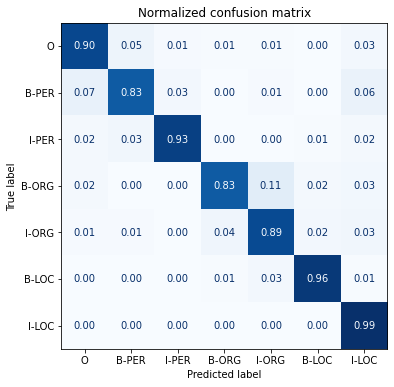

In [44]:
#@ PLOTTING CONFUSION MATRIX:
def plot_confusion_matrix(y_preds, y_true, labels):                             # Defining function. 
    cm = confusion_matrix(y_true, y_preds, normalize="true")                    # Initializing confusion matrix.
    fig, ax = plt.subplots(figsize=(6, 6))                                      # Initialization.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)   # Initializing confusion matrix display.
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)         # Plotting.
    plt.title("Normalized confusion matrix")
    plt.show()

#@ IMPLEMENTATION:
plot_confusion_matrix(df_tokens["predicted_label"], df_tokens["labels"], 
                      tags.names)

In [45]:
#@ INSPECTING TOKEN SEQUENCES: 
def get_samples(df):                                                    # Defining function.
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []                  # Initialization. 
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])                         # Adding labels. 
                preds.append(row["predicted_label"][i])                 # Adding predicted labels.
                tokens.append(row["input_tokens"][i])                   # Adding tokens.
                losses.append(f"{row['loss'][i]:.2f}")                  # Adding loss.
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T      # Creating dataframe.
        yield df_tmp            

#@ IMPLEMENTATION:
df["total_loss"] = df["loss"].apply(sum)                                # Adding loss.
df_tmp = df.sort_values(by="total_loss", ascending=False).head(5)       # Initializing dataframe.
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.34,0.00,0.00,0.00,10.17,9.88,7.95,8.09,8.39,0.00,8.69,8.98,0.00,9.30,9.46,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
tokens,▁Schwa,n,dorf,▁–,▁Cham,▁–,▁Fur,th,▁im,▁Wald,...,▁als,▁Teil,▁der,▁Fern,verbindung,▁München,▁-,▁Prag,▁),</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,...,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN
preds,B-LOC,B-LOC,I-LOC,O,B-LOC,O,B-LOC,I-LOC,I-LOC,I-LOC,...,I-LOC,O,O,O,O,B-LOC,I-LOC,B-LOC,I-LOC,O
losses,4.73,0.00,0.00,4.40,4.67,5.20,5.42,0.00,3.72,4.19,...,2.22,3.81,5.11,4.21,0.00,1.77,2.02,3.28,2.75,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.07,6.35,6.53,0.00,6.37,0.00,6.38,0.00,6.15,6.13,6.56,6.67,6.32,6.30,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.29,0.00,0.00,3.42,8.05,8.68,5.96,0.00,7.38,7.19,6.39,6.01,4.58,0.00,0.00,0.02,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁1988,▁in,▁Auckland,▁und,▁1989,▁in,▁Stavanger,▁tru,g,▁er,▁mit,▁einem,▁sie,b,ten,▁bzw,▁,.,</s>
labels,B-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,IGN,O,O,O,O,IGN,IGN,O,O,IGN,IGN
preds,O,O,B-LOC,O,O,O,B-LOC,O,O,O,O,O,O,O,O,O,O,O,O
losses,3.88,9.76,7.29,0.00,4.05,9.39,7.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [52]:
#@ INSPECTING OPEN PARENTHESIS:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9
tokens,▁Pam,plo,na,▁-,▁Vi,ana,▁(,▁Navarra,▁),</s>
labels,B-LOC,IGN,IGN,O,B-LOC,IGN,I-LOC,I-LOC,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,B-LOC
losses,0.05,0.00,0.00,0.01,0.03,0.00,0.00,0.01,0.01,0.00


,0,1,2,3,4,5,6,7,8
tokens,▁Cle,mens,▁VIII,.,▁(,▁Pap,st,▁),</s>
labels,B-PER,IGN,I-PER,IGN,I-PER,I-PER,IGN,I-PER,IGN
preds,B-PER,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### **Cross-Lingual Transfer**

In [46]:
#@ EVALUATION ON MULTIPLE LANGUAGES: IMPORTANT:
def get_f1_score(trainer, dataset):                             # Defining function.
    return trainer.predict(dataset).metrics["test_f1"]          # Getting f1 score.

In [47]:
#@ MODEL PERFORMANCE ON TEST DATASET:
f1_scores = defaultdict(dict)                                                   # Initializing dictionary.
f1_scores["de"]["de"] = get_f1_score(trainer, 
                                     panx_de_encoded["test"])                   # Getting f1 score.
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")   # Inspection.

F1-score of [de] model on [de] dataset: 0.864


In [48]:
#@ INSPECTING MODEL PERFORMANCE ON FRENCH: 
text_fr = "Jeff Dean est informaticien chez Google en Californie"               # Initializing text.
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)                          # Inspection.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,B-LOC,O


In [49]:
#@ EVALUATION OF PAN-X LANGUAGES: IMPORTANT:
def evaluate_lang_performance(lang, trainer):               # Defining function.                  
    panx_ds = encode_panx_dataset(panx_ch[lang])            # Encoding dataset.
    return get_f1_score(trainer, panx_ds["test"])           # F1 score on test dataset.

In [54]:
#@ IMPLEMENTATION ON FRENCH DATASET:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)                # Implementation.
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")   # Inspection.

  0%|          | 0/5 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-17b34755b551ad0b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2528fe72e754fa78.arrow


F1-score of [de] model on [fr] dataset: 0.729


In [63]:
#@ IMPLEMENTATION ON ITALIAN DATASET:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)                # Implementation.
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")   # Inspection.

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-0d011d2b65742086.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-639b50d87e1e3dd7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-da2ec01a6417acae.arrow


F1-score of [de] model on [it] dataset: 0.658


In [64]:
#@ IMPLEMENTATION ON ENGLISH DATASET:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)                # Implementation.
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")   # Inspection.

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b66c836d4276ec27.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1bc4582bb21ac460.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-dd87826dfc1b6121.arrow


F1-score of [de] model on [en] dataset: 0.591


In [50]:
#@ FUNCTION TO FINE-TUNE XLM-R MODEL: IMPORTANT:
def train_on_subset(dataset, num_samples):                                          # Defining function. 
    train_ds = dataset["train"].shuffle(seed=2022).select(range(num_samples))       # Initializing training dataset.
    valid_ds = dataset["validation"]                                                # Initializing validation dataset.
    test_ds = dataset["test"]                                                       # Initializing test dataset.
    training_args.logging_steps = len(train_ds) // batch_size                       # Initializing logging steps.
    trainer = Trainer(model_init=model_init, args=training_args, 
                      data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=train_ds, eval_dataset=valid_ds,                # Training and validation dataset.
                      tokenizer=xlmr_tokenizer)                                     # Initializing trainer. 
    trainer.train()                                                                 # Training the trainer model.
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")                   # Pushing to hub.
    f1_score = get_f1_score(trainer, test_ds)                                       # Getting f1 scores.
    return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], 
                                   "f1_score": f1_score})                           # Getting dataframe.

In [51]:
#@ FINE-TUNING WITH FRENCH CORPUS:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])                                # Encoding french dataset.
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 200)                                  # Implementation of funtion.
metrics_df

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,F1
1,1.921700,1.412960,0.001899
2,1.428000,1.269929,0.058604
3,1.255600,1.164589,0.115176


,num_samples,f1_score
0,200,0.122155


In [52]:
#@ FINE-TUNING WITH FRENCH CORPUS: INCREASING TRAINING SET:
for num_samples in [400]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)       # Implementation.

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a910b4a8a23320db.arrow


Epoch,Training Loss,Validation Loss,F1
1,1.656500,1.177004,0.131535
2,1.063500,0.816487,0.481619
3,0.779300,0.703334,0.548086


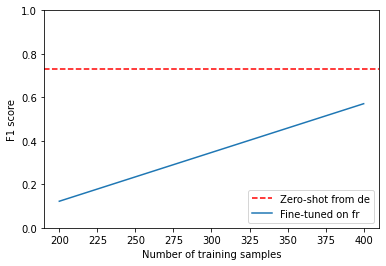

In [55]:
#@ PLOTTING F1 SCORES:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of training samples")
plt.ylabel("F1 score")
plt.show()

### **Fine-Tuning Multiple Languages**

In [57]:
#@ FUNCTION TO CONCATENATE DATASET:
def concatenate_splits(corpora):                                        # Defining function.
    multi_corpus = DatasetDict()                                        # Initialization.
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=2022)   # Initializing multi corpus.
    return multi_corpus

#@ IMPLEMENTATION:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded,
                                         panx_fr_encoded])              # Implementation.

In [58]:
#@ TRAINING THE MODEL:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size        # Initializing training logs. 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"                  # Initialization.
trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_fr_encoded["train"], 
                  eval_dataset=panx_de_fr_encoded["validation"],                    # Validation dataset.
                  tokenizer=xlmr_tokenizer)                                         # Initializing trainer.
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.285400,0.184471,0.826331
2,0.142900,0.160440,0.841947
3,0.090800,0.163271,0.860465


TrainOutput(global_step=2145, training_loss=0.17303146682419143, metrics={'train_runtime': 1313.9794, 'train_samples_per_second': 39.179, 'train_steps_per_second': 1.632, 'total_flos': 1131251766906240.0, 'train_loss': 0.17303146682419143, 'epoch': 3.0})

In [60]:
#@ INSPECTING MODEL PERFORMANCE: 
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)                       # Implementation.
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")   # Inspecting f1 score. 

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-5536e31f64c74e10.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-5e1da0ee67f278e1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c3a89d9efa0b632d.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-de9189e48180c3aa.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-17b34755b551ad0b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2528fe72e754fa78.arrow


F1-score of [de-fr] model on [de] dataset: 0.867
F1-score of [de-fr] model on [fr] dataset: 0.867


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [it] dataset: 0.799


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [en] dataset: 0.664


In [ ]:
#@ FINE-TUNING ON MULTIPLE LANGUAGES:
corpora = [panx_de_encoded]                                                 # Initialization.
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    f1_scores[lang][lang] = metrics["f1_score"][0]                          # Adding f1 scores. 
    corpora.append(ds_encoded)

#@ INITIALIZING CONCATENATION:
corpora_encoded = concatenate_splits(corpora)

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-de9189e48180c3aa.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-17b34755b551ad0b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2528fe72e754fa78.arrow


In [ ]:
#@ TRAINING THE MODEL:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size           # Initializing training logs. 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"                    # Initialization.
trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=corpora_encoded["train"], 
                  eval_dataset=corpora_encoded["validation"],                       # Validation dataset.
                  tokenizer=xlmr_tokenizer)                                         # Initializing trainer.
trainer.train()

In [ ]:
#@ SUMMARIZING MULTILINGUAL LEARNING:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {"de": f1_scores["de"], 
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}                                             # Dictionary of f1 scores.
f1_scores_df = pd.DataFrame(scores_data).T.round(4)                                 # Creating dataframe.
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", 
                         inplace=True)
f1_scores_df